# Analisando atributos
Nesse arquivo vou comparar a eficiência de vários parâmetros através de plots para determinar quais irei utilizar no meu algorítimo K-NN. Vou focar mais em parâmetros relacionados a frequência dos sinais.

## Bibliotecas

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.io as io
import scipy.stats as stats
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler
import librosa
from tqdm import tqdm

import os
from typing import Tuple

Criando base de dados geral

In [116]:
dataFolder = "./Acordes"
files = os.listdir(dataFolder)

columns = ["file", "class"]

chords = pd.DataFrame(
    data= [],
    columns = columns,
    index= range(len(files))
)

for index, file in enumerate(files):
    
    className = file.split("_").pop(0)
    className = className.lower()

    sampleRate, audio = io.wavfile.read(f"{dataFolder}/{file}")

    chords.iloc[index] = [file, className]

chords.shape

(100, 2)

## Dataframe de atributos

Irei criar um dataframe com os atributos de cada amostra da base de dados. Os atributos escolhidos estarão normalizados com a normalização $z = \frac{x - \mu}{\sigma}$.

Lista de atributos:
- Média
- Desvio padrão
- Skewness
- Kurtose
- Média da fft
- Skewness da fft
- Curtose da fft


In [117]:
columns = ["file", "mean", "std", "skewness", "kurtosis", "class"]
major_chords = []

chords_attributes = pd.DataFrame(
    data= [],
    columns = columns, 
    index= range(len(files))
)

for index, file in enumerate(files):
    
    className = file.split("_").pop(0)
    className = className.lower()

    sampleRate, audio = io.wavfile.read(f"{dataFolder}/{file}")
    
    mean = np.mean(audio)
    std = np.std(audio)
    skewness = stats.skew(audio)
    kurtosis = stats.kurtosis(audio)

    chords_attributes.iloc[index] = [file, mean, std, skewness, kurtosis, className]

numeric_cols = ["mean", "std", "skewness", "kurtosis"]
chords_attributes[numeric_cols] = StandardScaler().fit_transform(chords_attributes[numeric_cols])

chords_attributes.shape

(100, 6)

## Primeira hipótese: Skewness da transformada de Fourier
A skewness mede o grau de simetria de uma distribuição e a transformada de Fourier muda o domínio da minha amostra para o domínio da frequência. A ideia seria:  
Acordes maiores possuem uma terça com frequência maior que a terça de acordes menores. Sendo assim, a distribuição de acordes menores deve tender um pouco mais  
pra esquerda em relação a acordes maiores.

### Transformada de Fourier

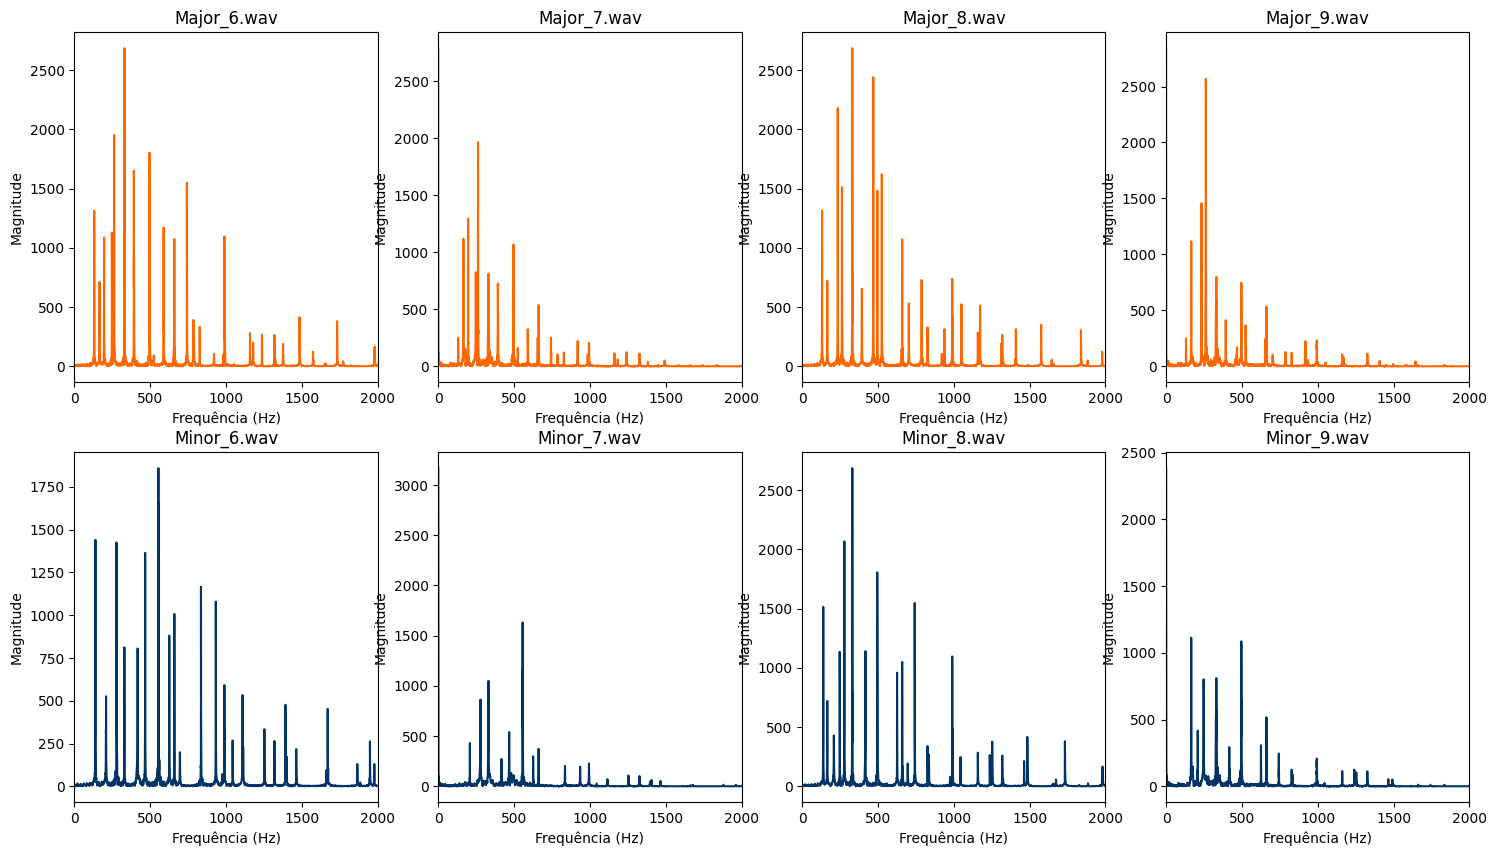

In [118]:
#Função para ler o arquivo de audio
def readAudio(audioFile:str)->Tuple[int, np.array]:
    return io.wavfile.read(f"{dataFolder}/{audioFile}")

#Funçao para calcular a fft
def calculateFFT(audio: np.array, sampleRate: int) -> Tuple[np.array, np.array]:
    N = len(audio)
    T = 1.0 / sampleRate

    audio = audio.astype(float)

    fft_values = np.fft.fft(audio)
    fft_frequencies = np.fft.fftfreq(N, T)

    #Pegando apenas as frequências positivas (para o skewness não ficar simétrico)
    idx = np.where(fft_frequencies >= 0) 

    #Normalizando as amplitudes (Mantendo a energia mesmo com o corte da metade negativa)
    amplitudes = 2.0 / N * np.abs(fft_values[idx])

    return fft_frequencies[idx], amplitudes


# Pegando 4 amostras de cada classe
major_chords = chords[chords["class"] == "major"]["file"].tail(4)
minor_chords= chords[chords["class"] == "minor"]["file"].tail(4)


# Calculando a FFT para cada acorde maior e plotando os resultados
fig, axes = plt.subplots(2,4, figsize=(18, 10))

for i, chord in enumerate(major_chords):
    sampleRate, audio = readAudio(chord)
    frequencies, fft_values = calculateFFT(audio, sampleRate)

    axes[0][i].plot(frequencies, fft_values, color="#ff6600")
    axes[0][i].set_title(chord)
    axes[0][i].set_xlabel("Frequência (Hz)")
    axes[0][i].set_ylabel("Magnitude")
    axes[0][i].set_xlim(0, 2000)

for i, chord in enumerate(minor_chords):
    sampleRate, audio = readAudio(chord)
    frequencies, fft_values = calculateFFT(audio, sampleRate)
    axes[1][i].plot(frequencies, fft_values, color="#003366")
    axes[1][i].set_title(chord)
    axes[1][i].set_xlabel("Frequência (Hz)")
    axes[1][i].set_ylabel("Magnitude")
    axes[1][i].set_xlim(0, 2000)




Agora irei calcular o skewness dessa transformada de fourier.

In [119]:
# Creando uma nova coluna com os valores de skewness da FFT
chords_attributes["FFT_skewness"] = chords_attributes["file"].apply(
    lambda file: stats.skew(calculateFFT(readAudio(file)[1], readAudio(file)[0])[1])
)

#Normalizando a coluna de skewness da FFT
chords_attributes["FFT_skewness"] = StandardScaler().fit_transform(
    chords_attributes[["FFT_skewness"]]
)

chords_attributes.head()


file      mean       std  skewness  kurtosis  class  FFT_skewness
0   Major_0.wav -0.978784  0.841934 -0.648675 -0.611911  major     -0.776569
1   Major_1.wav  1.099954  0.015608  0.954677 -0.120714  major      0.800353
2  Major_10.wav -0.979883  0.813109 -0.981712 -0.935719  major     -0.173633
3  Major_11.wav  0.737474 -0.695597  1.368172  0.111714  major     -0.141709
4  Major_12.wav -0.978954  0.871567 -0.805537 -0.978717  major     -0.507814

## Kurtose da FFT

In [120]:
# Creando uma nova coluna com os valores da curtose das FFT
chords_attributes["FFT_kurtosis"] = chords_attributes["file"].apply(
    lambda file: stats.kurtosis(calculateFFT(readAudio(file)[1], readAudio(file)[0])[1])
)

#Normalizando a coluna de skewness da FFT
chords_attributes["FFT_kurtosis"] = StandardScaler().fit_transform(
    chords_attributes[["FFT_kurtosis"]]
)

chords_attributes.head()

file      mean       std  skewness  kurtosis  class  FFT_skewness  \
0   Major_0.wav -0.978784  0.841934 -0.648675 -0.611911  major     -0.776569   
1   Major_1.wav  1.099954  0.015608  0.954677 -0.120714  major      0.800353   
2  Major_10.wav -0.979883  0.813109 -0.981712 -0.935719  major     -0.173633   
3  Major_11.wav  0.737474 -0.695597  1.368172  0.111714  major     -0.141709   
4  Major_12.wav -0.978954  0.871567 -0.805537 -0.978717  major     -0.507814   

   FFT_kurtosis  
0     -0.704986  
1      0.619204  
2     -0.420248  
3     -0.183398  
4     -0.711351

Fazendo o pairplot dos atributos para verificar o quão bons são para a classificação

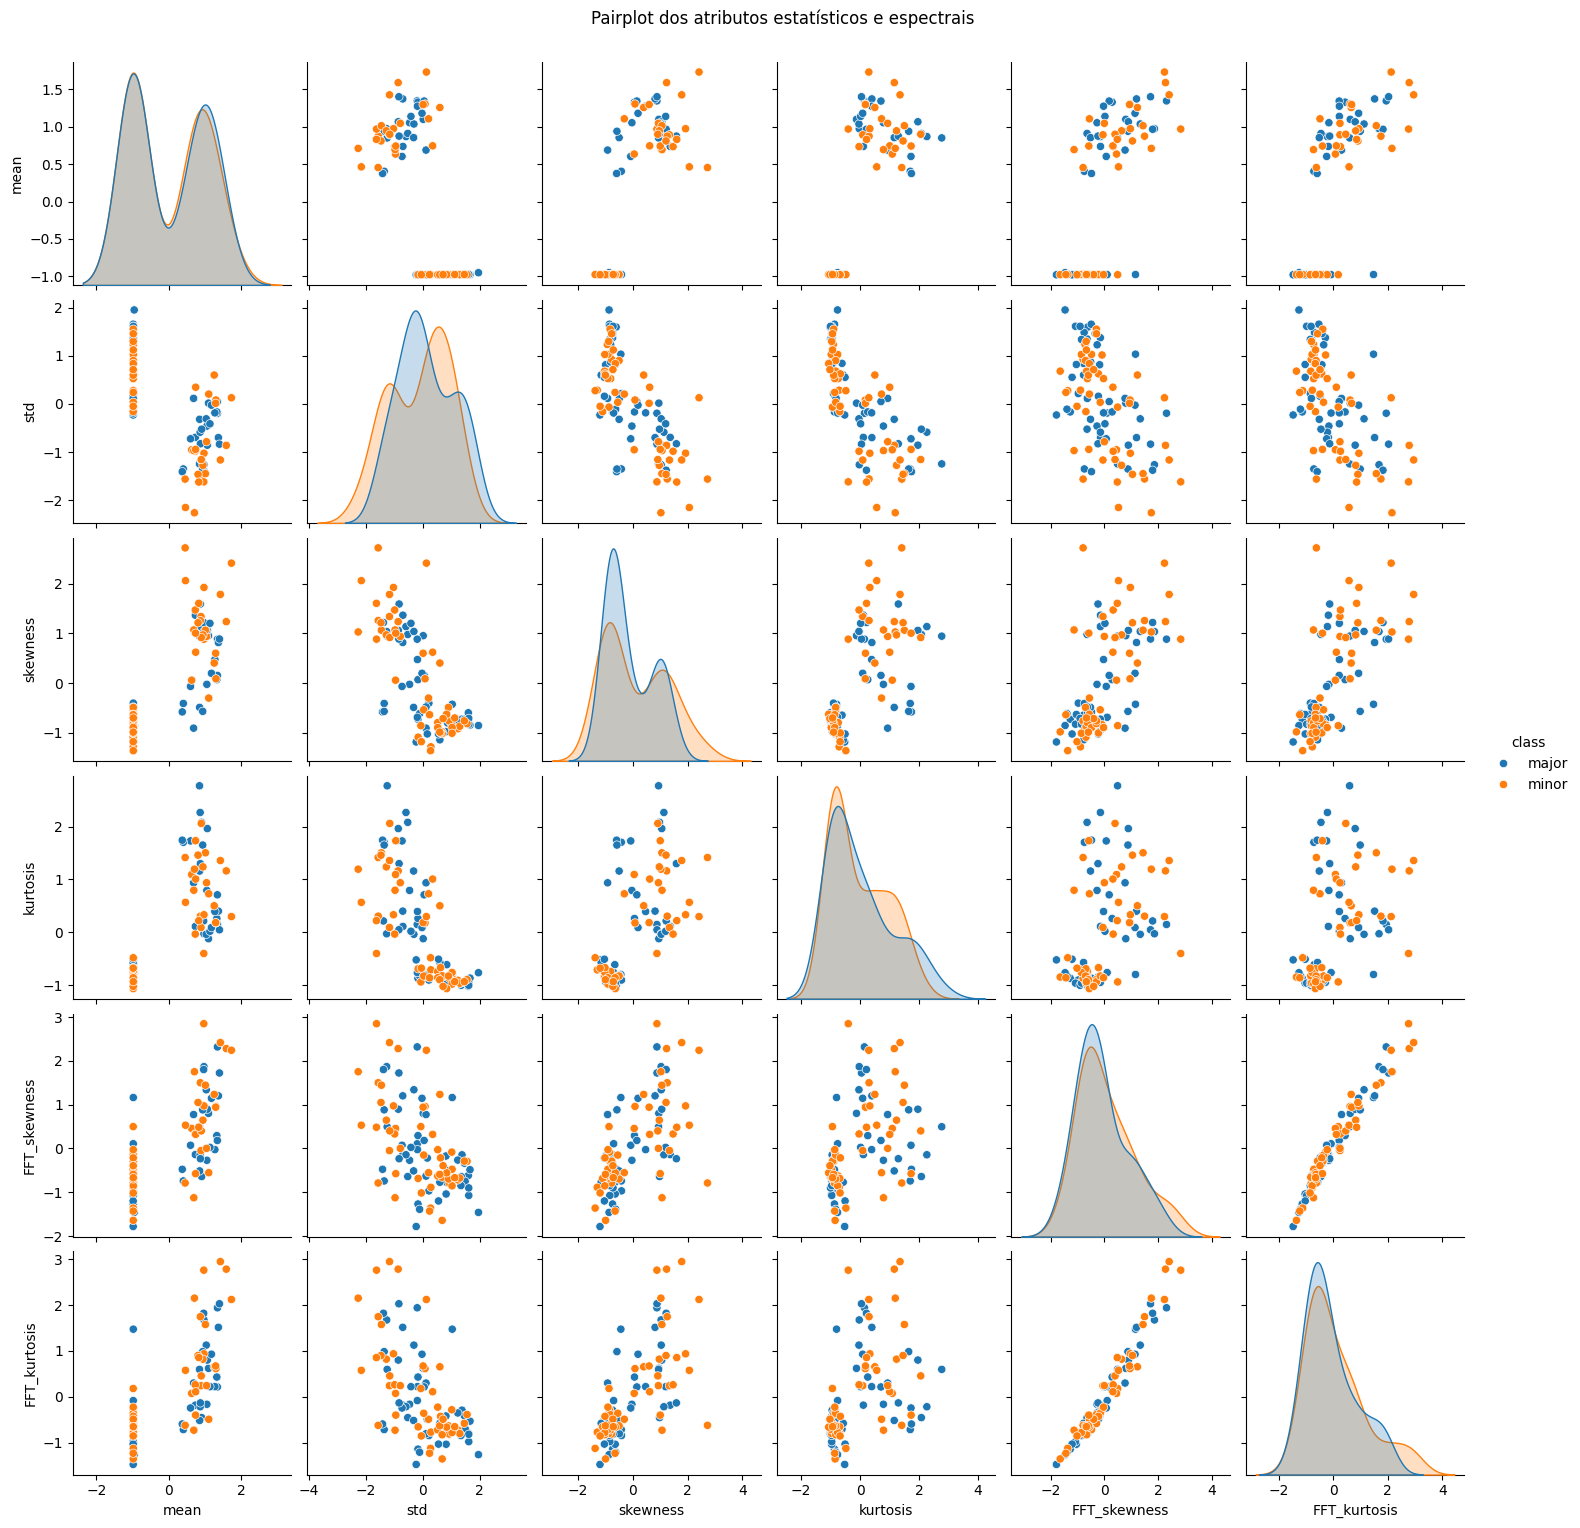

In [121]:
cols_to_plot = ["mean", "std", "skewness", "kurtosis", "FFT_skewness", "FFT_kurtosis", "class"]

sns.pairplot(chords_attributes[cols_to_plot], hue="class", diag_kind="kde")
plt.suptitle("Pairplot dos atributos estatísticos e espectrais", y=1.02)

plt.show()

De maneira geral, todos esses atributos são bem horríveis como classificadores, talvez só sejam relevantes se unidos com outros atributos.

## Segunda hipótese: Proporção dos intervalos de frequência

Tentarei determinar quais dos picos correspondem a tônica, terça e quinta e vou medir a proporção da distância da tonica para a terça e da terça para a quinta. Definitivamente esse deveria ser um excelente atributo para determinar se um acorde é maior ou menor, já que faz parte da própria definição do acorde. Vou fazer isso primeiro com apenas 1 amostra.

### Encontrando os picos

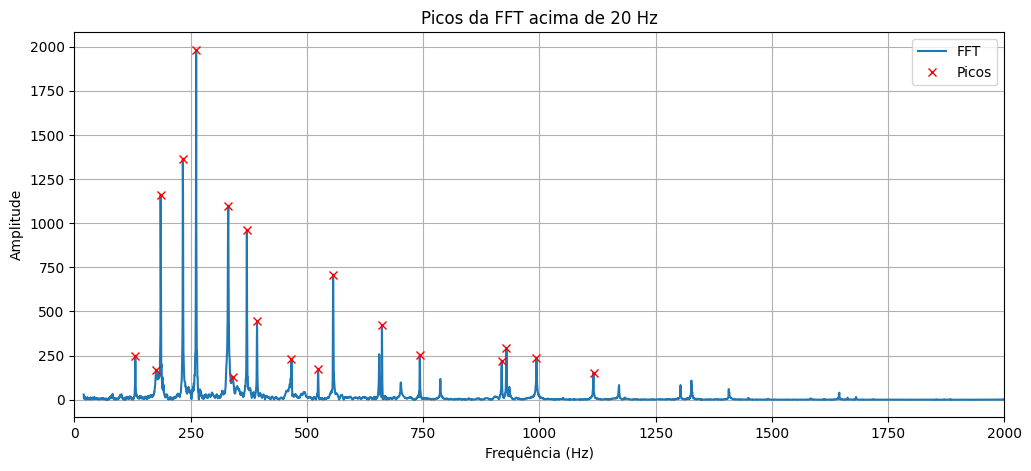

In [122]:
def find_notes(file: str, threshold: float = 0.06, plot_peaks: bool = False) -> np.array:
    sampleRate, sample = readAudio(file)
    frequencies, fft_values = calculateFFT(sample, sampleRate)

    #Removendo frequencias abaixo de 20Hz (inaudíveis) porque essas frequencias podem ter sido geradas por ruídos
    idx = frequencies >= 20
    frequencies = frequencies[idx]
    fft_values = fft_values[idx]

    #Definindo uma limiar de magnitude para os picos
    magnitude_threshold = threshold * np.max(fft_values)

    # Encontrando os picos
    peaks, _ = find_peaks(fft_values, height=magnitude_threshold, distance=20)

    notes = np.round(frequencies[peaks], 2)

    # Determinando a frequência e amplitude dos picos
    peak_frequencies = frequencies[peaks]
    peak_amplitudes = fft_values[peaks]

    # Plot dos picos encontrados
    if plot_peaks:
        plt.figure(figsize=(12, 5))
        plt.plot(frequencies, fft_values, label="FFT")
        plt.plot(peak_frequencies, peak_amplitudes, "rx", label="Picos")

        plt.title("Picos da FFT acima de 20 Hz")
        plt.xlabel("Frequência (Hz)")
        plt.ylabel("Amplitude")
        plt.xlim(0, 2000)
        plt.legend()
        plt.grid(True)

        plt.show()

    return notes


#Testando a função:
notes = find_notes(files[3], plot_peaks=True)

### Encontrando os intervalos entre os picos

Agora eu tenho os picos, mas não sei qual desses picos se trata da tônica, terça ou quinta. Acho que vou tentar usar os própios picos como atributos, mesmo sem saber qual se trata das notas que geram o acorde. Vou criar mais um dataframe do pandas para armazenar os picos.


In [123]:
chord_peaks = pd.DataFrame(
    data = chords[["file", "class"]],
    columns=["file", "class"],
    index= range(len(files))
)

chord_peaks["peak_list"] = chords["file"].apply(find_notes)

#Aqui eu determino o número de picos em cada acorde
chord_peaks["n_peaks"] = chord_peaks["peak_list"].apply(len)

chord_peaks.describe()




n_peaks
count  100.000000
mean    18.590000
std      4.449708
min      9.000000
25%     15.000000
50%     19.000000
75%     22.000000
max     26.000000

Com o describe do número de picos obtive a informação de que todos os acordes tem no mínimo 9 picos, então vou trabalhar apenas com eles e excluir os outros.

In [124]:
n_picos = 9

peak_df = pd.DataFrame(chord_peaks["peak_list"].tolist()).iloc[:, :n_picos]
peak_df.columns = [f"peak_{i+1}" for i in range(n_picos)]

# Convertendo os tipos de dados dos picos para float
for col in peak_df.columns:
    peak_df[col] = peak_df[col].astype(float)

chord_peaks = pd.concat([chord_peaks.drop(columns=[col for col in chord_peaks.columns if col.startswith('peak_')], errors='ignore'), peak_df], axis=1)

#Deletando a coluna original de picos devido a redundância
del peak_df

chord_peaks.head()

file  class  n_peaks  peak_1  peak_2  peak_3  peak_4  peak_5  \
0   Major_0.wav  major       20  130.67  165.33  196.00  262.22  330.22   
1   Major_1.wav  major       12  131.11  165.33  196.44  261.78  331.11   
2  Major_10.wav  major       20  130.91  185.00  234.09  262.27  329.55   
3  Major_11.wav  major       18  130.91  175.91  185.45  233.18  261.82   
4  Major_12.wav  major       22  165.45  234.09  262.27  330.45  415.45   

   peak_6  peak_7  peak_8  peak_9  
0  392.00  495.56  524.89  588.44  
1  392.44  496.00  524.00  589.78  
2  370.45  393.18  468.18  555.45  
3  330.91  340.00  370.91  392.73  
4  468.18  495.45  524.55  660.91

Agora, com os picos, vou calcular o que realmente importa no acorde, a razão entre os intervalos. Vou gerar mais colunas de intervalos entre os picos:

In [125]:
for i in range(1, n_picos):
    chord_peaks[f"interval_{i}"] = chord_peaks[f"peak_{i+1}"] / chord_peaks[f"peak_{i}"]

chord_peaks.head()

file  class  n_peaks  peak_1  peak_2  peak_3  peak_4  peak_5  \
0   Major_0.wav  major       20  130.67  165.33  196.00  262.22  330.22   
1   Major_1.wav  major       12  131.11  165.33  196.44  261.78  331.11   
2  Major_10.wav  major       20  130.91  185.00  234.09  262.27  329.55   
3  Major_11.wav  major       18  130.91  175.91  185.45  233.18  261.82   
4  Major_12.wav  major       22  165.45  234.09  262.27  330.45  415.45   

   peak_6  peak_7  peak_8  peak_9  interval_1  interval_2  interval_3  \
0  392.00  495.56  524.89  588.44    1.265248    1.185508    1.337857   
1  392.44  496.00  524.00  589.78    1.261002    1.188169    1.332621   
2  370.45  393.18  468.18  555.45    1.413185    1.265351    1.120381   
3  330.91  340.00  370.91  392.73    1.343748    1.054232    1.257374   
4  468.18  495.45  524.55  660.91    1.414869    1.120381    1.259961   

   interval_4  interval_5  interval_6  interval_7  interval_8  
0    1.259324    1.187087    1.264184    1.059186    1.121073  
1    1.264841    1.185225    1.263887    1.056452    1.125534  
2    1.256530    1.124109    1.061358    1.190752    1.186403  
3    1.122824    1.263884    1.027470    1.090912    1.058828  
4    1.257225    1.126923    1.058247    1.058734    1.259956

C:\Users\ryyam\AppData\Local\Temp\ipykernel_18480\2057929466.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=chord_peaks, x=f"interval_{i}", hue="class", shade=True)
C:\Users\ryyam\AppData\Local\Temp\ipykernel_18480\2057929466.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=chord_peaks, x=f"interval_{i}", hue="class", shade=True)
C:\Users\ryyam\AppData\Local\Temp\ipykernel_18480\2057929466.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=chord_peaks, x=f"interval_{i}", hue="class", shade=True)
C:\Users\ryyam\AppData\Local\Temp\ipykernel_18480\2057929466.py:10: FutureWarning: 

`shade` is now 

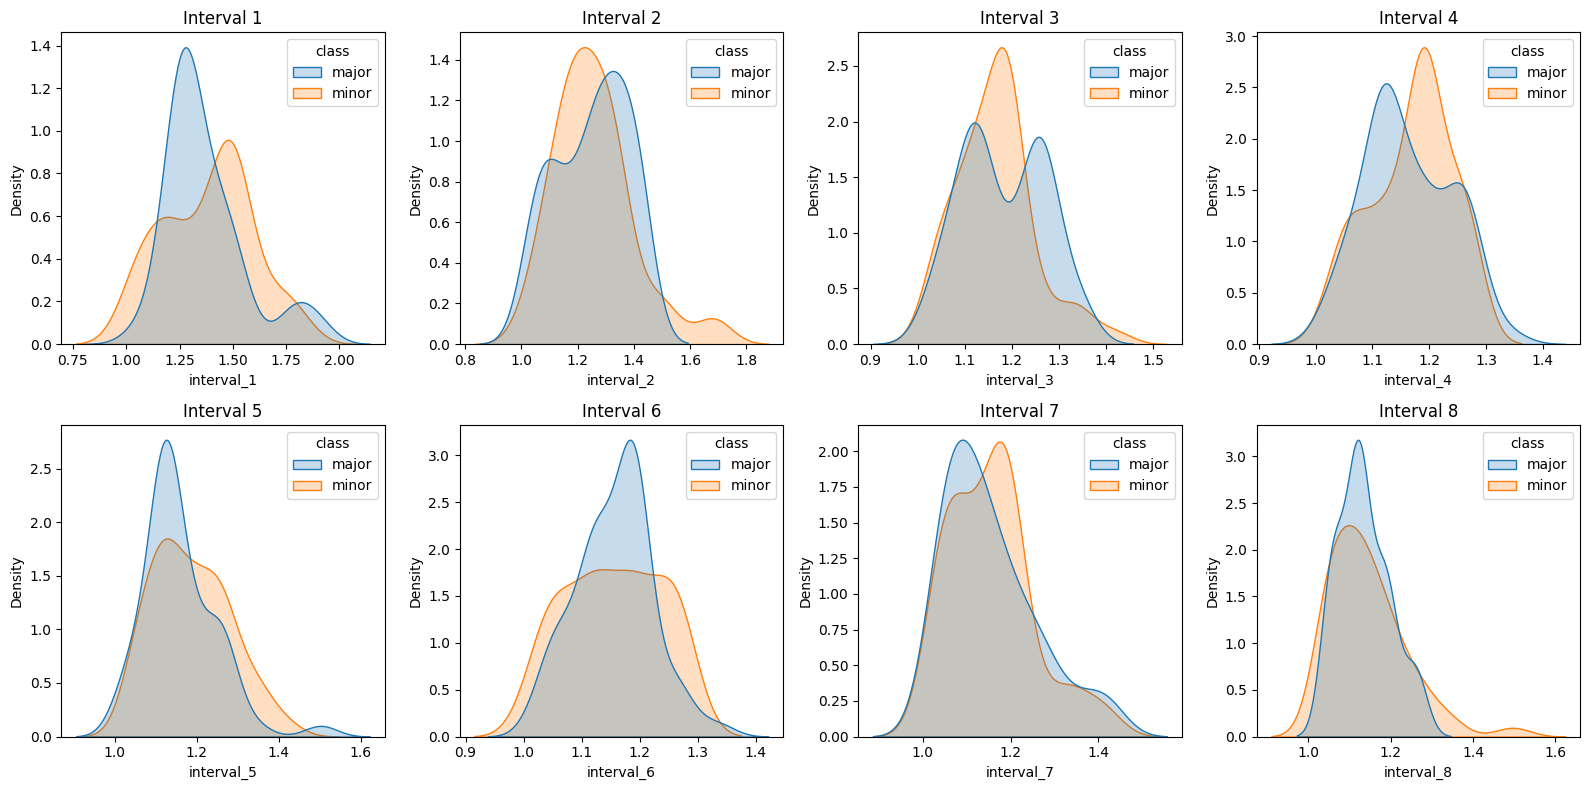

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns

n_intervals = 8  # número de intervalos que você tem

fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # 2 linhas, 4 colunas, ajuste o tamanho

for i in range(1, n_intervals + 1):
    plt.subplot(2, 4, i)
    sns.kdeplot(data=chord_peaks, x=f"interval_{i}", hue="class", shade=True)
    plt.title(f"Interval {i}")

fig.tight_layout()
plt.show()

Por mais que a distribuição dos picos esteja um pouco sobreposta, o formato da distribuição é diferente entre os picos maiores e menores e vou utilizar isso como parâmetros. Vou considerar todos os 6 primeiros intervalos (o 7 e o 8 tem formatos semelhantes). Agora vou calcular intervalos com saltos, como por exemplo, o intervalo entre o pico 1 e o pico 3.

C:\Users\ryyam\AppData\Local\Temp\ipykernel_18480\10471107.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=interval_values, hue=chord_peaks["class"], shade=True, ax=ax)
C:\Users\ryyam\AppData\Local\Temp\ipykernel_18480\10471107.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=interval_values, hue=chord_peaks["class"], shade=True, ax=ax)
C:\Users\ryyam\AppData\Local\Temp\ipykernel_18480\10471107.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=interval_values, hue=chord_peaks["class"], shade=True, ax=ax)
C:\Users\ryyam\AppData\Local\Temp\ipykernel_18480\10471107.py:19: FutureWarning: 

`shade` is now de

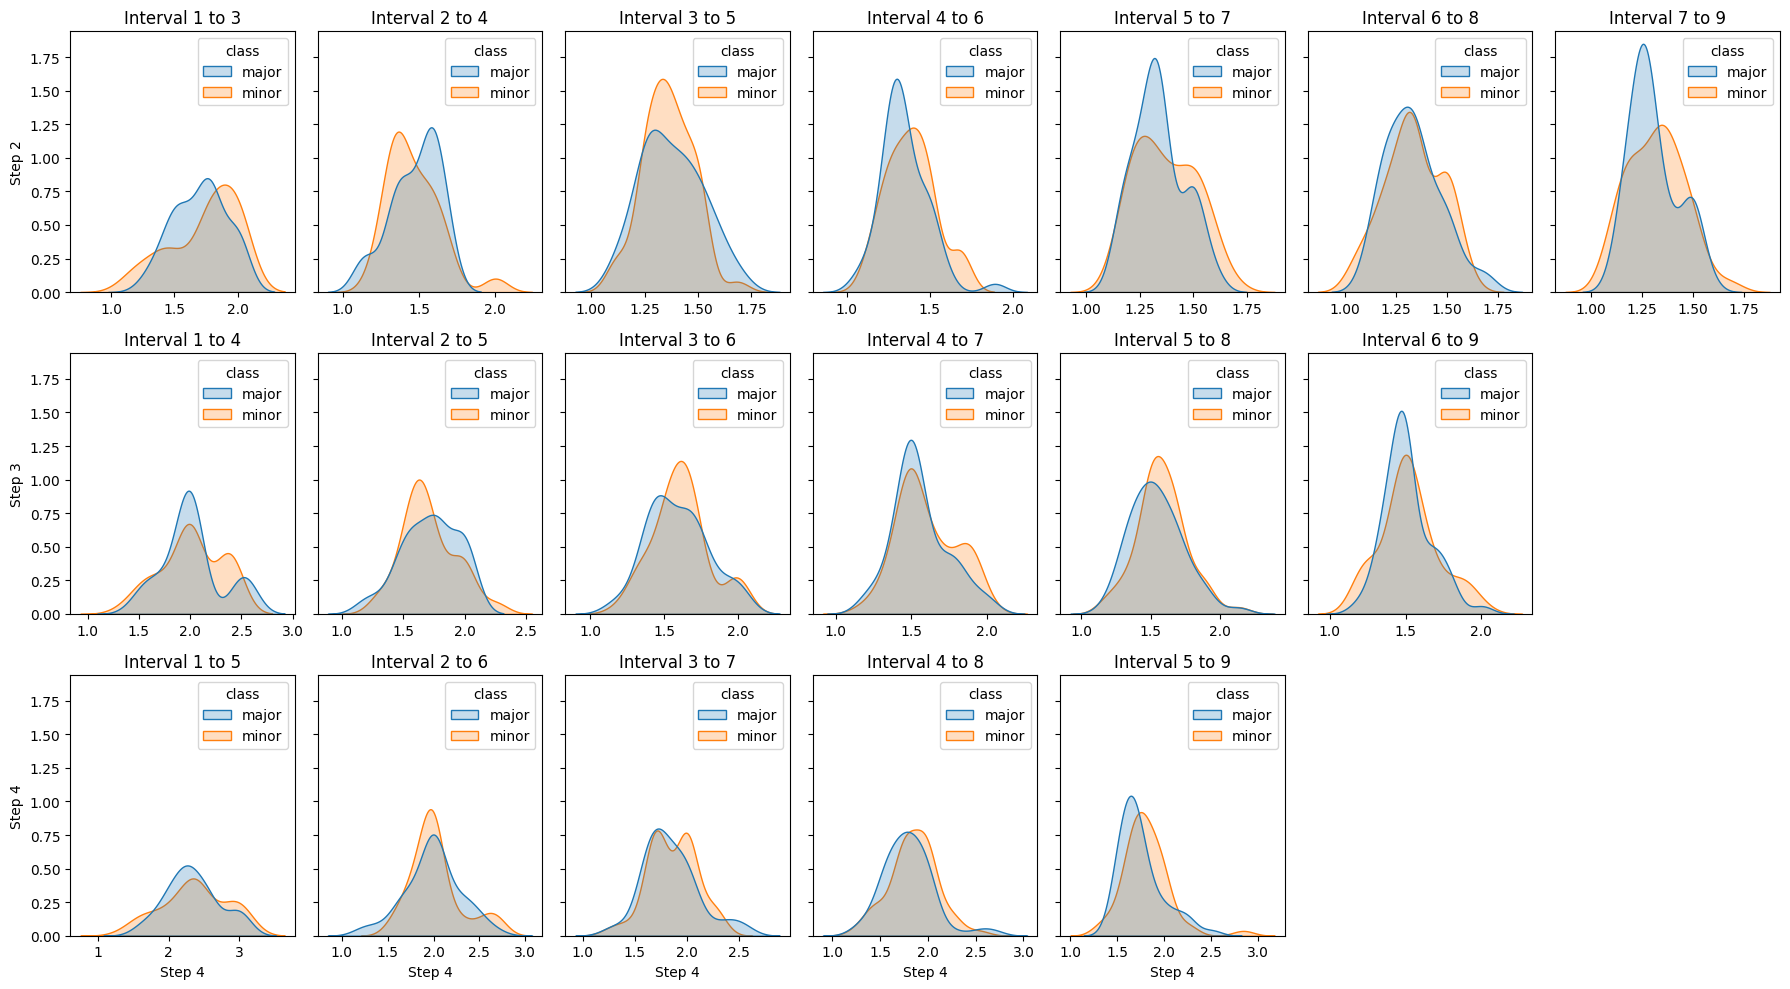

In [127]:
steps = [2,3,4]
max_step = max(steps)

max_harmonic = n_picos

num_cols = max_harmonic - min(steps)  
fig, axes = plt.subplots(len(steps), num_cols, figsize=(18, 10), sharey=True)

for row_idx, step in enumerate(steps):
    for i in range(1, max_harmonic - step + 1):
        harm1 = f"peak_{i}"
        harm2 = f"peak_{i + step}"
        interval_col = f"Interval_{i}_{i+step}"
        
        # Calcula o intervalo temporariamente
        interval_values = chord_peaks[harm2] / chord_peaks[harm1]
        
        ax = axes[row_idx, i - 1]
        sns.kdeplot(x=interval_values, hue=chord_peaks["class"], shade=True, ax=ax)
        ax.set_title(f"Interval {i} to {i+step}")
        
        if row_idx == len(steps) - 1:
            ax.set_xlabel(f"Step {step}")
        else:
            ax.set_xlabel("")
        if i == 1:
            ax.set_ylabel(f"Step {step}")
        else:
            ax.set_ylabel("")

# Esconde eixos extras
for ax in axes.flat:
    if not ax.has_data():
        ax.axis('off')

plt.tight_layout()
plt.show()

Meio complicado escolher um atributo, mas irei decidir com base na maior área separada e diferença no formato das curvas. Sendo assim, vou considerar: 
- Intervalo [1-3]
- Invervalo [1-4]
- Invervalo [1-5]
- Invervalo [3-5]
- Invervalo [3-6]

Enfim, meus parâmetros serão:
- Intervalo 1
- Intervalo 3
- Intervalo 4
- Intervalo 6
- Intervalo [1-3]
- Invervalo [1-4]

Adicionando os intervalos [1-3] e [1-4] no dataframe

In [128]:
chord_peaks["Interval[1-3]"] = chord_peaks["peak_3"] / chord_peaks["peak_1"]
chord_peaks["Interval[1-4]"] = chord_peaks["peak_4"] / chord_peaks["peak_1"]

chord_peaks.head()

file  class  n_peaks  peak_1  peak_2  peak_3  peak_4  peak_5  \
0   Major_0.wav  major       20  130.67  165.33  196.00  262.22  330.22   
1   Major_1.wav  major       12  131.11  165.33  196.44  261.78  331.11   
2  Major_10.wav  major       20  130.91  185.00  234.09  262.27  329.55   
3  Major_11.wav  major       18  130.91  175.91  185.45  233.18  261.82   
4  Major_12.wav  major       22  165.45  234.09  262.27  330.45  415.45   

   peak_6  peak_7  ...  interval_1  interval_2  interval_3  interval_4  \
0  392.00  495.56  ...    1.265248    1.185508    1.337857    1.259324   
1  392.44  496.00  ...    1.261002    1.188169    1.332621    1.264841   
2  370.45  393.18  ...    1.413185    1.265351    1.120381    1.256530   
3  330.91  340.00  ...    1.343748    1.054232    1.257374    1.122824   
4  468.18  495.45  ...    1.414869    1.120381    1.259961    1.257225   

   interval_5  interval_6  interval_7  interval_8  Interval[1-3]  \
0    1.187087    1.264184    1.059186    1.121073       1.499962   
1    1.185225    1.263887    1.056452    1.125534       1.498284   
2    1.124109    1.061358    1.190752    1.186403       1.788175   
3    1.263884    1.027470    1.090912    1.058828       1.416622   
4    1.126923    1.058247    1.058734    1.259956       1.585192   

   Interval[1-4]  
0       2.006735  
1       1.996644  
2       2.003437  
3       1.781224  
4       1.997280  

[5 rows x 22 columns]

Agora vou adicionar os parâmetros de intervalos no meu dataframe chords_attributes e também vou normalizar esses dados com o Z-Score


In [129]:
# Filtrando as colunas de intervalo
interval_cols = [col for col in chord_peaks.columns if "interval" in col.lower()]

# Criando um novo DataFrame apenas com as colunas de intervalo
intervals_only = chord_peaks[interval_cols].reset_index(drop=True)
chords_attributes = pd.concat([chords_attributes.reset_index(drop=True), intervals_only], axis=1)

# Normalizando as colunas de intervalo
chords_attributes[interval_cols] = StandardScaler().fit_transform(chords_attributes[interval_cols])

chords_attributes.head()

file      mean       std  skewness  kurtosis  class  FFT_skewness  \
0   Major_0.wav -0.978784  0.841934 -0.648675 -0.611911  major     -0.776569   
1   Major_1.wav  1.099954  0.015608  0.954677 -0.120714  major      0.800353   
2  Major_10.wav -0.979883  0.813109 -0.981712 -0.935719  major     -0.173633   
3  Major_11.wav  0.737474 -0.695597  1.368172  0.111714  major     -0.141709   
4  Major_12.wav -0.978954  0.871567 -0.805537 -0.978717  major     -0.507814   

   FFT_kurtosis  interval_1  interval_2  interval_3  interval_4  interval_5  \
0     -0.704986   -0.566282   -0.512331    1.945798    1.304765    0.165638   
1      0.619204   -0.588024   -0.492308    1.883701    1.380998    0.145091   
2     -0.420248    0.191236    0.088398   -0.633153    1.266145   -0.529336   
3     -0.183398   -0.164321   -1.500025    0.991384   -0.581550    1.013087   
4     -0.711351    0.199858   -1.002333    1.022064    1.275756   -0.498283   

   interval_6  interval_7  interval_8  Interval[1-3]  Interval[1-4]  
0    1.493784   -0.963349   -0.236693      -0.913464      -0.010816  
1    1.489714   -0.991063   -0.179521      -0.920559      -0.045621  
2   -1.293051    0.370359    0.600499       0.305355      -0.022188  
3   -1.758674   -0.641737   -1.034352      -1.265897      -0.788659  
4   -1.335796   -0.967921    1.543078      -0.553036      -0.043427

### Definindo chords_attributes

Dessa forma, os atributos afeitos até agora estarão guardados na tabela chords_atributes. Vou gerar um CSV dessa tabela para que eu possa importá-lo no arquivo do K-NN em si.

In [130]:
chords_attributes.to_csv('./parameters_dataframes/chords_attributes.csv', index=False)

chords_attributes.head()

file      mean       std  skewness  kurtosis  class  FFT_skewness  \
0   Major_0.wav -0.978784  0.841934 -0.648675 -0.611911  major     -0.776569   
1   Major_1.wav  1.099954  0.015608  0.954677 -0.120714  major      0.800353   
2  Major_10.wav -0.979883  0.813109 -0.981712 -0.935719  major     -0.173633   
3  Major_11.wav  0.737474 -0.695597  1.368172  0.111714  major     -0.141709   
4  Major_12.wav -0.978954  0.871567 -0.805537 -0.978717  major     -0.507814   

   FFT_kurtosis  interval_1  interval_2  interval_3  interval_4  interval_5  \
0     -0.704986   -0.566282   -0.512331    1.945798    1.304765    0.165638   
1      0.619204   -0.588024   -0.492308    1.883701    1.380998    0.145091   
2     -0.420248    0.191236    0.088398   -0.633153    1.266145   -0.529336   
3     -0.183398   -0.164321   -1.500025    0.991384   -0.581550    1.013087   
4     -0.711351    0.199858   -1.002333    1.022064    1.275756   -0.498283   

   interval_6  interval_7  interval_8  Interval[1-3]  Interval[1-4]  
0    1.493784   -0.963349   -0.236693      -0.913464      -0.010816  
1    1.489714   -0.991063   -0.179521      -0.920559      -0.045621  
2   -1.293051    0.370359    0.600499       0.305355      -0.022188  
3   -1.758674   -0.641737   -1.034352      -1.265897      -0.788659  
4   -1.335796   -0.967921    1.543078      -0.553036      -0.043427

## Terceira hipótese: MFCCs
Geralmente é utilizado para reconhecimento de sinais sonoros e aproxima o sinal sonoro da forma que os humanos escutam.
Irei começar usando os 13 primeiros MFFCs

Recomendo que não procure entender o código abaixo, apenas aceite que colhi atributos do MFCCs através da biblioteca librosa e armazenei em um dataframe

In [131]:
mfcc_cols = [f"mfcc_{i}" for i in range(13)]
chroma_cols = [f"chroma_{i}" for i in range(12)]
freq_cols = ["freq1", "freq2", "freq3", "interval1", "interval2"]
all_cols = ["file", "class"] + mfcc_cols + chroma_cols + freq_cols


chords_MFCCs = pd.DataFrame(index=chords.index, columns=all_cols)

for idx, file in enumerate(tqdm(chords["file"])):
    try:
        y, sr = librosa.load(f"{dataFolder}/{file}", sr=None)

        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfccs, axis=1)

        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)

        spectrum = np.abs(np.fft.rfft(y))
        freqs = np.fft.rfftfreq(len(y), 1/sr)
        top_indices = np.argsort(spectrum)[-3:]
        top_freqs = freqs[top_indices]
        top_freqs.sort()
        mfcc_interval1 = top_freqs[1] - top_freqs[0]
        mfcc_interval2 = top_freqs[2] - top_freqs[1]

        # Preenchendo dados fixos
        chords_MFCCs.loc[idx, "file"] = file
        chords_MFCCs.loc[idx, "class"] = chords.loc[idx, "class"]

        # Preenchendo as colunas dos atributos
        chords_MFCCs.loc[idx, mfcc_cols] = mfcc_mean
        chords_MFCCs.loc[idx, chroma_cols] = chroma_mean
        chords_MFCCs.loc[idx, freq_cols] = list(top_freqs) + [mfcc_interval1, mfcc_interval2]

    except Exception as e:
        print(f"Erro no arquivo {file}: {e}")
        chords_MFCCs.loc[idx] = np.nan

chords_MFCCs.head()

100%|██████████| 100/100 [00:02<00:00, 43.22it/s]


file  class      mfcc_0      mfcc_1     mfcc_2     mfcc_3  \
0   Major_0.wav  major -338.311646  257.160645  37.915321 -19.911049   
1   Major_1.wav  major -404.383301  179.529099  68.798615   6.593409   
2  Major_10.wav  major -355.251312  251.063858  58.341755  -14.42813   
3  Major_11.wav  major -417.598999  184.266571  63.811138   3.704776   
4  Major_12.wav  major -333.408539  247.070435  29.524984  -34.49157   

      mfcc_4    mfcc_5     mfcc_6     mfcc_7  ...  chroma_7  chroma_8  \
0   0.432726   1.77978 -10.046961  -20.09708  ...   0.43424   0.23324   
1  -3.544342  1.101167   3.221654   1.498808  ...  0.407608  0.289689   
2  -2.209613   3.59497  -6.423003  -9.328892  ...  0.370034  0.154589   
3   -4.20575   0.48366   4.296622     2.7536  ...  0.298764  0.226407   
4 -14.624427 -5.707579  -5.588033 -10.901041  ...  0.212523  0.453391   

   chroma_9 chroma_10 chroma_11       freq1       freq2       freq3  \
0  0.064293  0.170337  0.616393  330.222222       392.0  524.888889   
1  0.186409  0.200456  0.496897         0.0  261.777778  262.222222   
2  0.439698  0.933742  0.583076  234.090909  370.454545  468.181818   
3   0.37017  0.587017  0.659805         0.0  233.181818  261.818182   
4  0.405999  0.851877   0.83764  234.090909  330.454545  468.181818   

    interval1   interval2  
0   61.777778  132.888889  
1  261.777778    0.444444  
2  136.363636   97.727273  
3  233.181818   28.636364  
4   96.363636  137.727273  

[5 rows x 32 columns]

Agora vou normalizar as colunas usando z-score

In [132]:
cols_to_scale = chords_MFCCs.columns.drop(["file", "class"])
chords_MFCCs[cols_to_scale] = StandardScaler().fit_transform(chords_MFCCs[cols_to_scale])

chords_MFCCs.head()

file  class    mfcc_0    mfcc_1    mfcc_2    mfcc_3    mfcc_4  \
0   Major_0.wav  major  0.877174  1.026916 -0.556108 -0.665970  0.666087   
1   Major_1.wav  major -0.804121 -0.883676  1.255906  1.283044 -0.155795   
2  Major_10.wav  major  0.446118  0.876868  0.642371 -0.262782  0.120034   
3  Major_11.wav  major -1.140415 -0.767082  0.963276  1.070627 -0.292478   
4  Major_12.wav  major  1.001941  0.778585 -1.048394 -1.738154 -2.445553   

     mfcc_5    mfcc_6    mfcc_7  ...  chroma_7  chroma_8  chroma_9  chroma_10  \
0  0.012591 -0.983117 -1.165128  ...  0.681732 -0.356065 -1.299441  -0.981533   
1 -0.165989  0.862655  1.190435  ...  0.546970 -0.008841 -0.696605  -0.857771   
2  0.490266 -0.478995  0.009408  ...  0.356846 -0.839851  0.553774   2.155300   
3 -0.328488  1.012192  1.327301  ... -0.003783 -0.398096  0.210546   0.730610   
4 -1.957739 -0.362844 -0.162074  ... -0.440171  0.998102  0.387419   1.818919   

   chroma_11     freq1     freq2     freq3  interval1  interval2  
0   0.480302  1.514925  0.702296  0.816067  -1.198063   0.494488  
1  -0.051511 -0.946726 -0.727729 -1.231282   0.522439  -1.112879  
2   0.332027  0.798311  0.465696  0.374065  -0.556437   0.067761  
3   0.673509 -0.946726 -1.041753 -1.234431   0.276442  -0.770738  
4   1.464960  0.798311  0.026440  0.374065  -0.900538   0.553207  

[5 rows x 32 columns]

Agora vou gerar um plot para comparar a eficiencia dos 13 mfccs

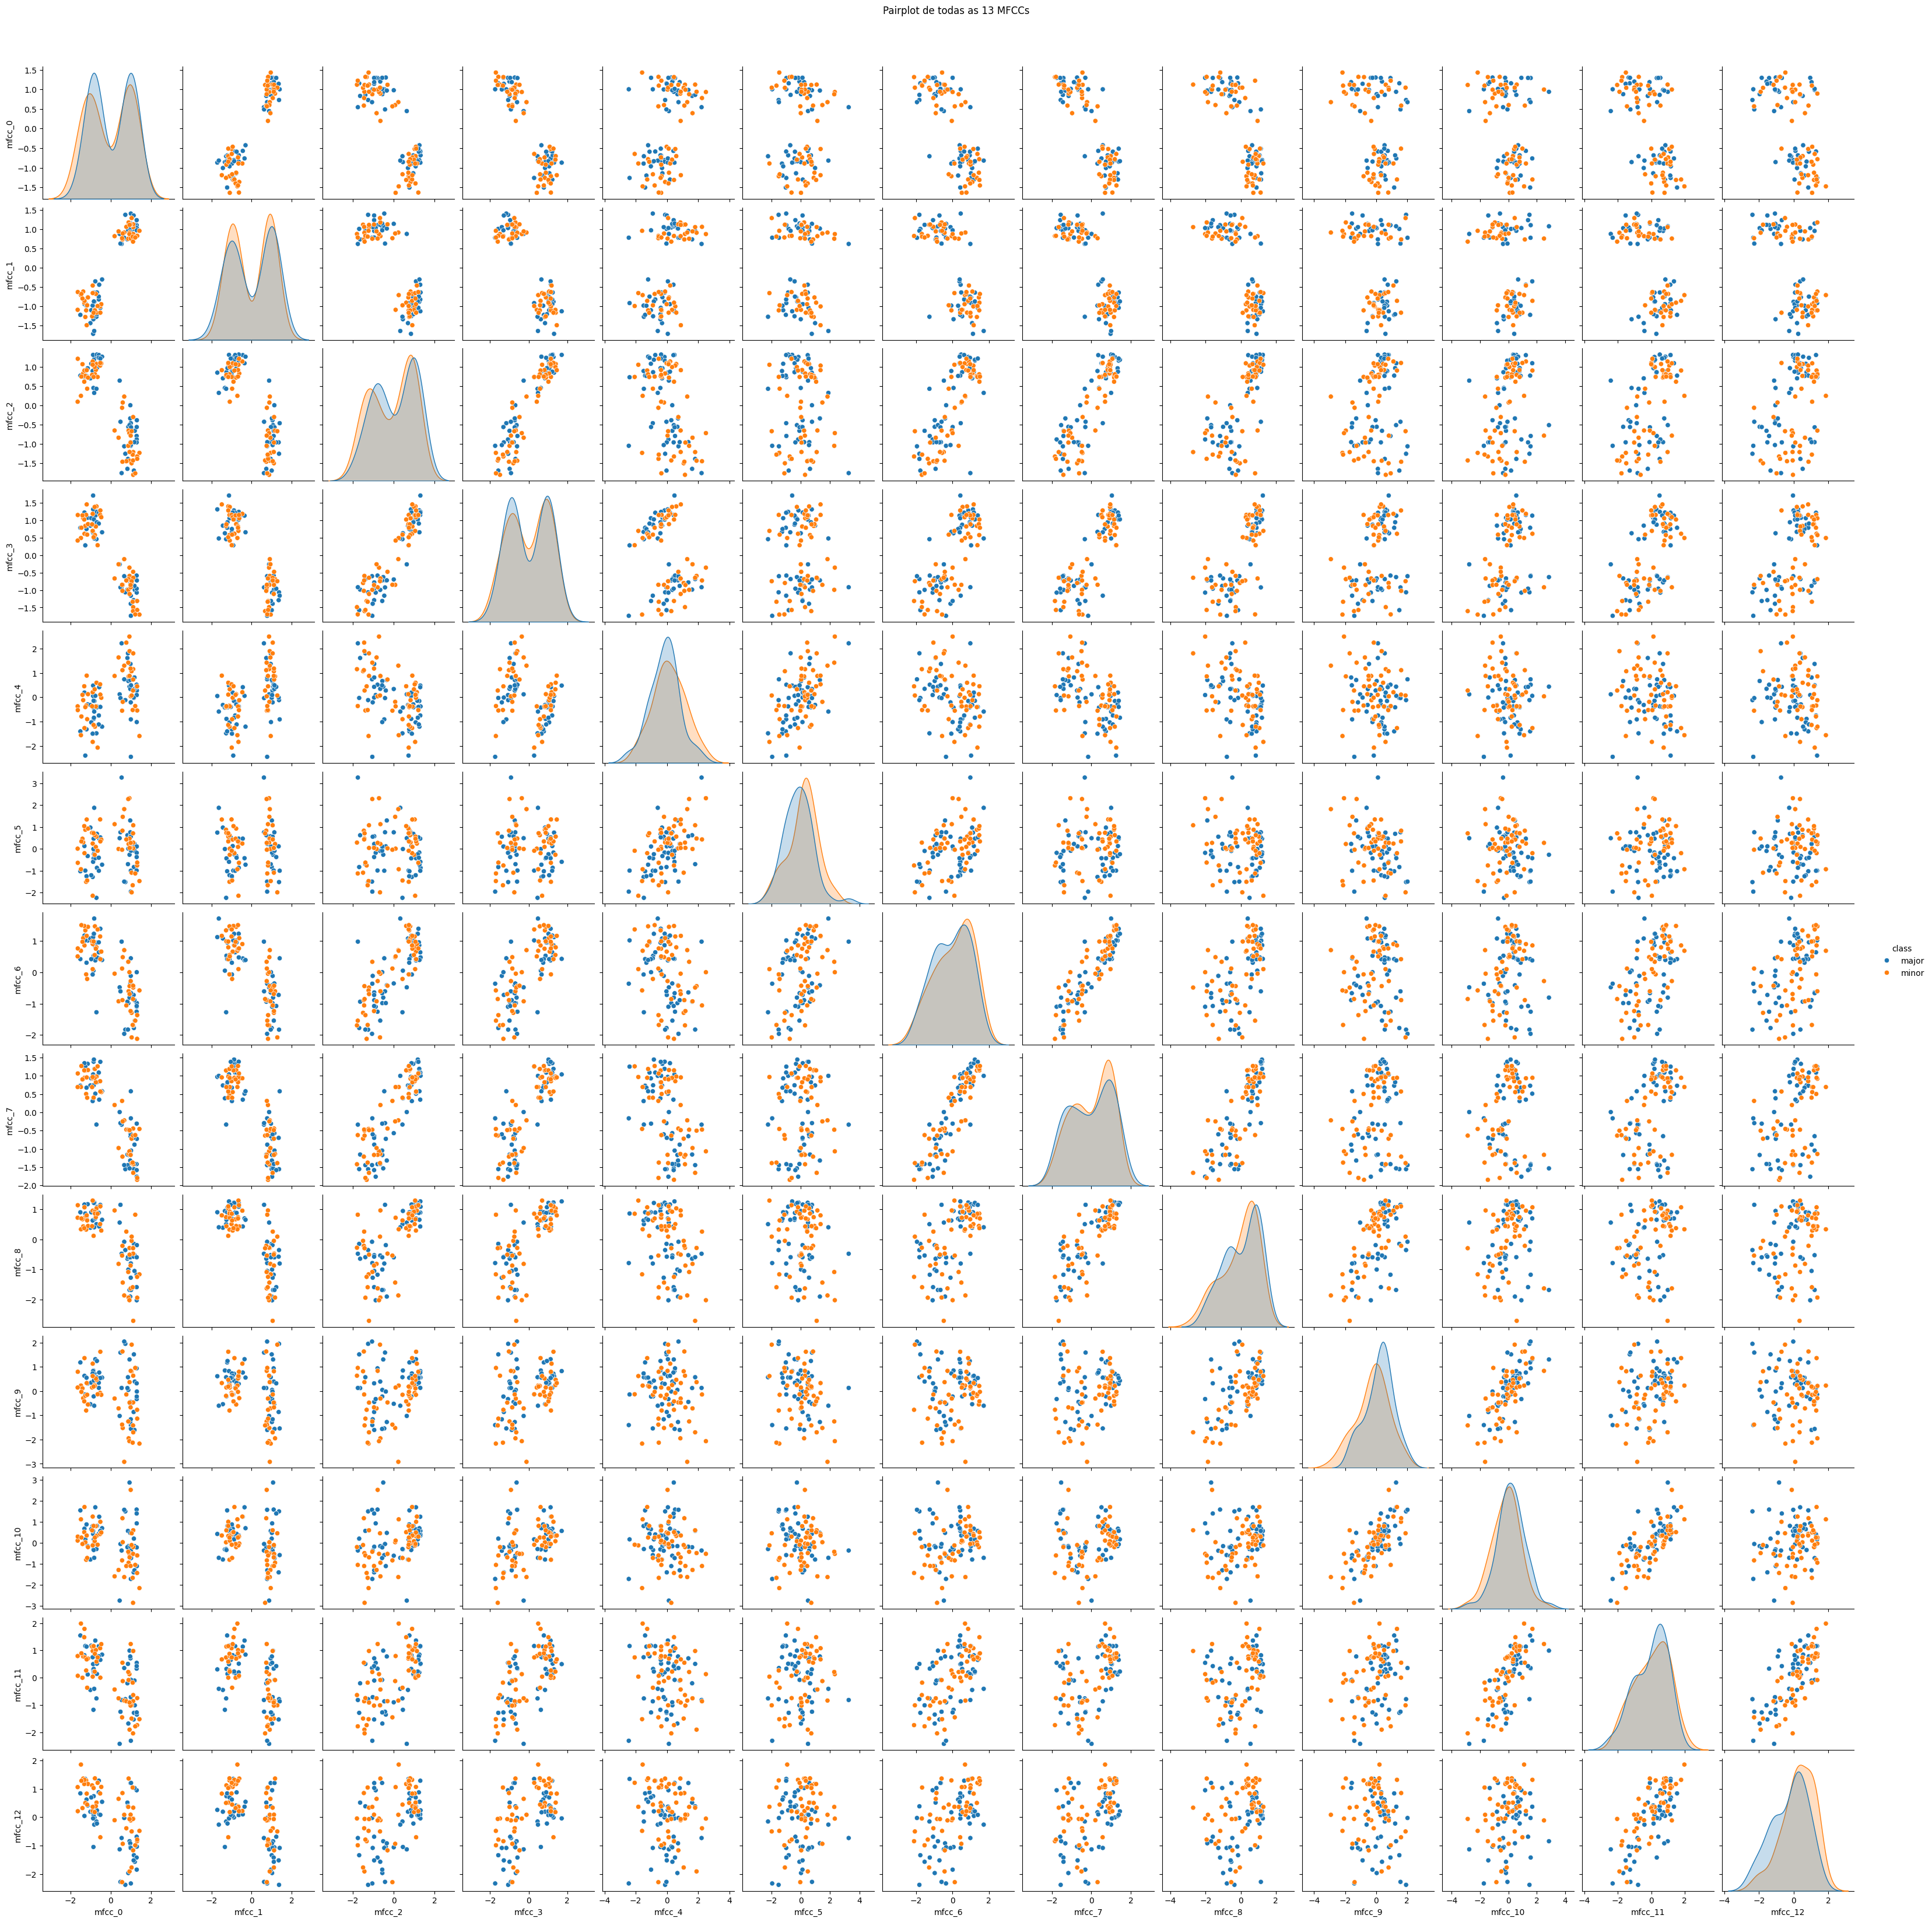

In [133]:
mfcc_cols = [f"mfcc_{i}" for i in range(13)]
cols_to_plot = mfcc_cols + ["class"]

sns.pairplot(chords_MFCCs[cols_to_plot], hue="class", diag_kind="kde")

plt.suptitle("Pairplot de todas as 13 MFCCs", y=1.02)
plt.show()

Verifiquei as combinações de cada um, e o MFCC (8-12) (10-11), (10-12) e o (11-12) parecem muito promissores

E vou plotar as outras características extraidas pelos mfccs

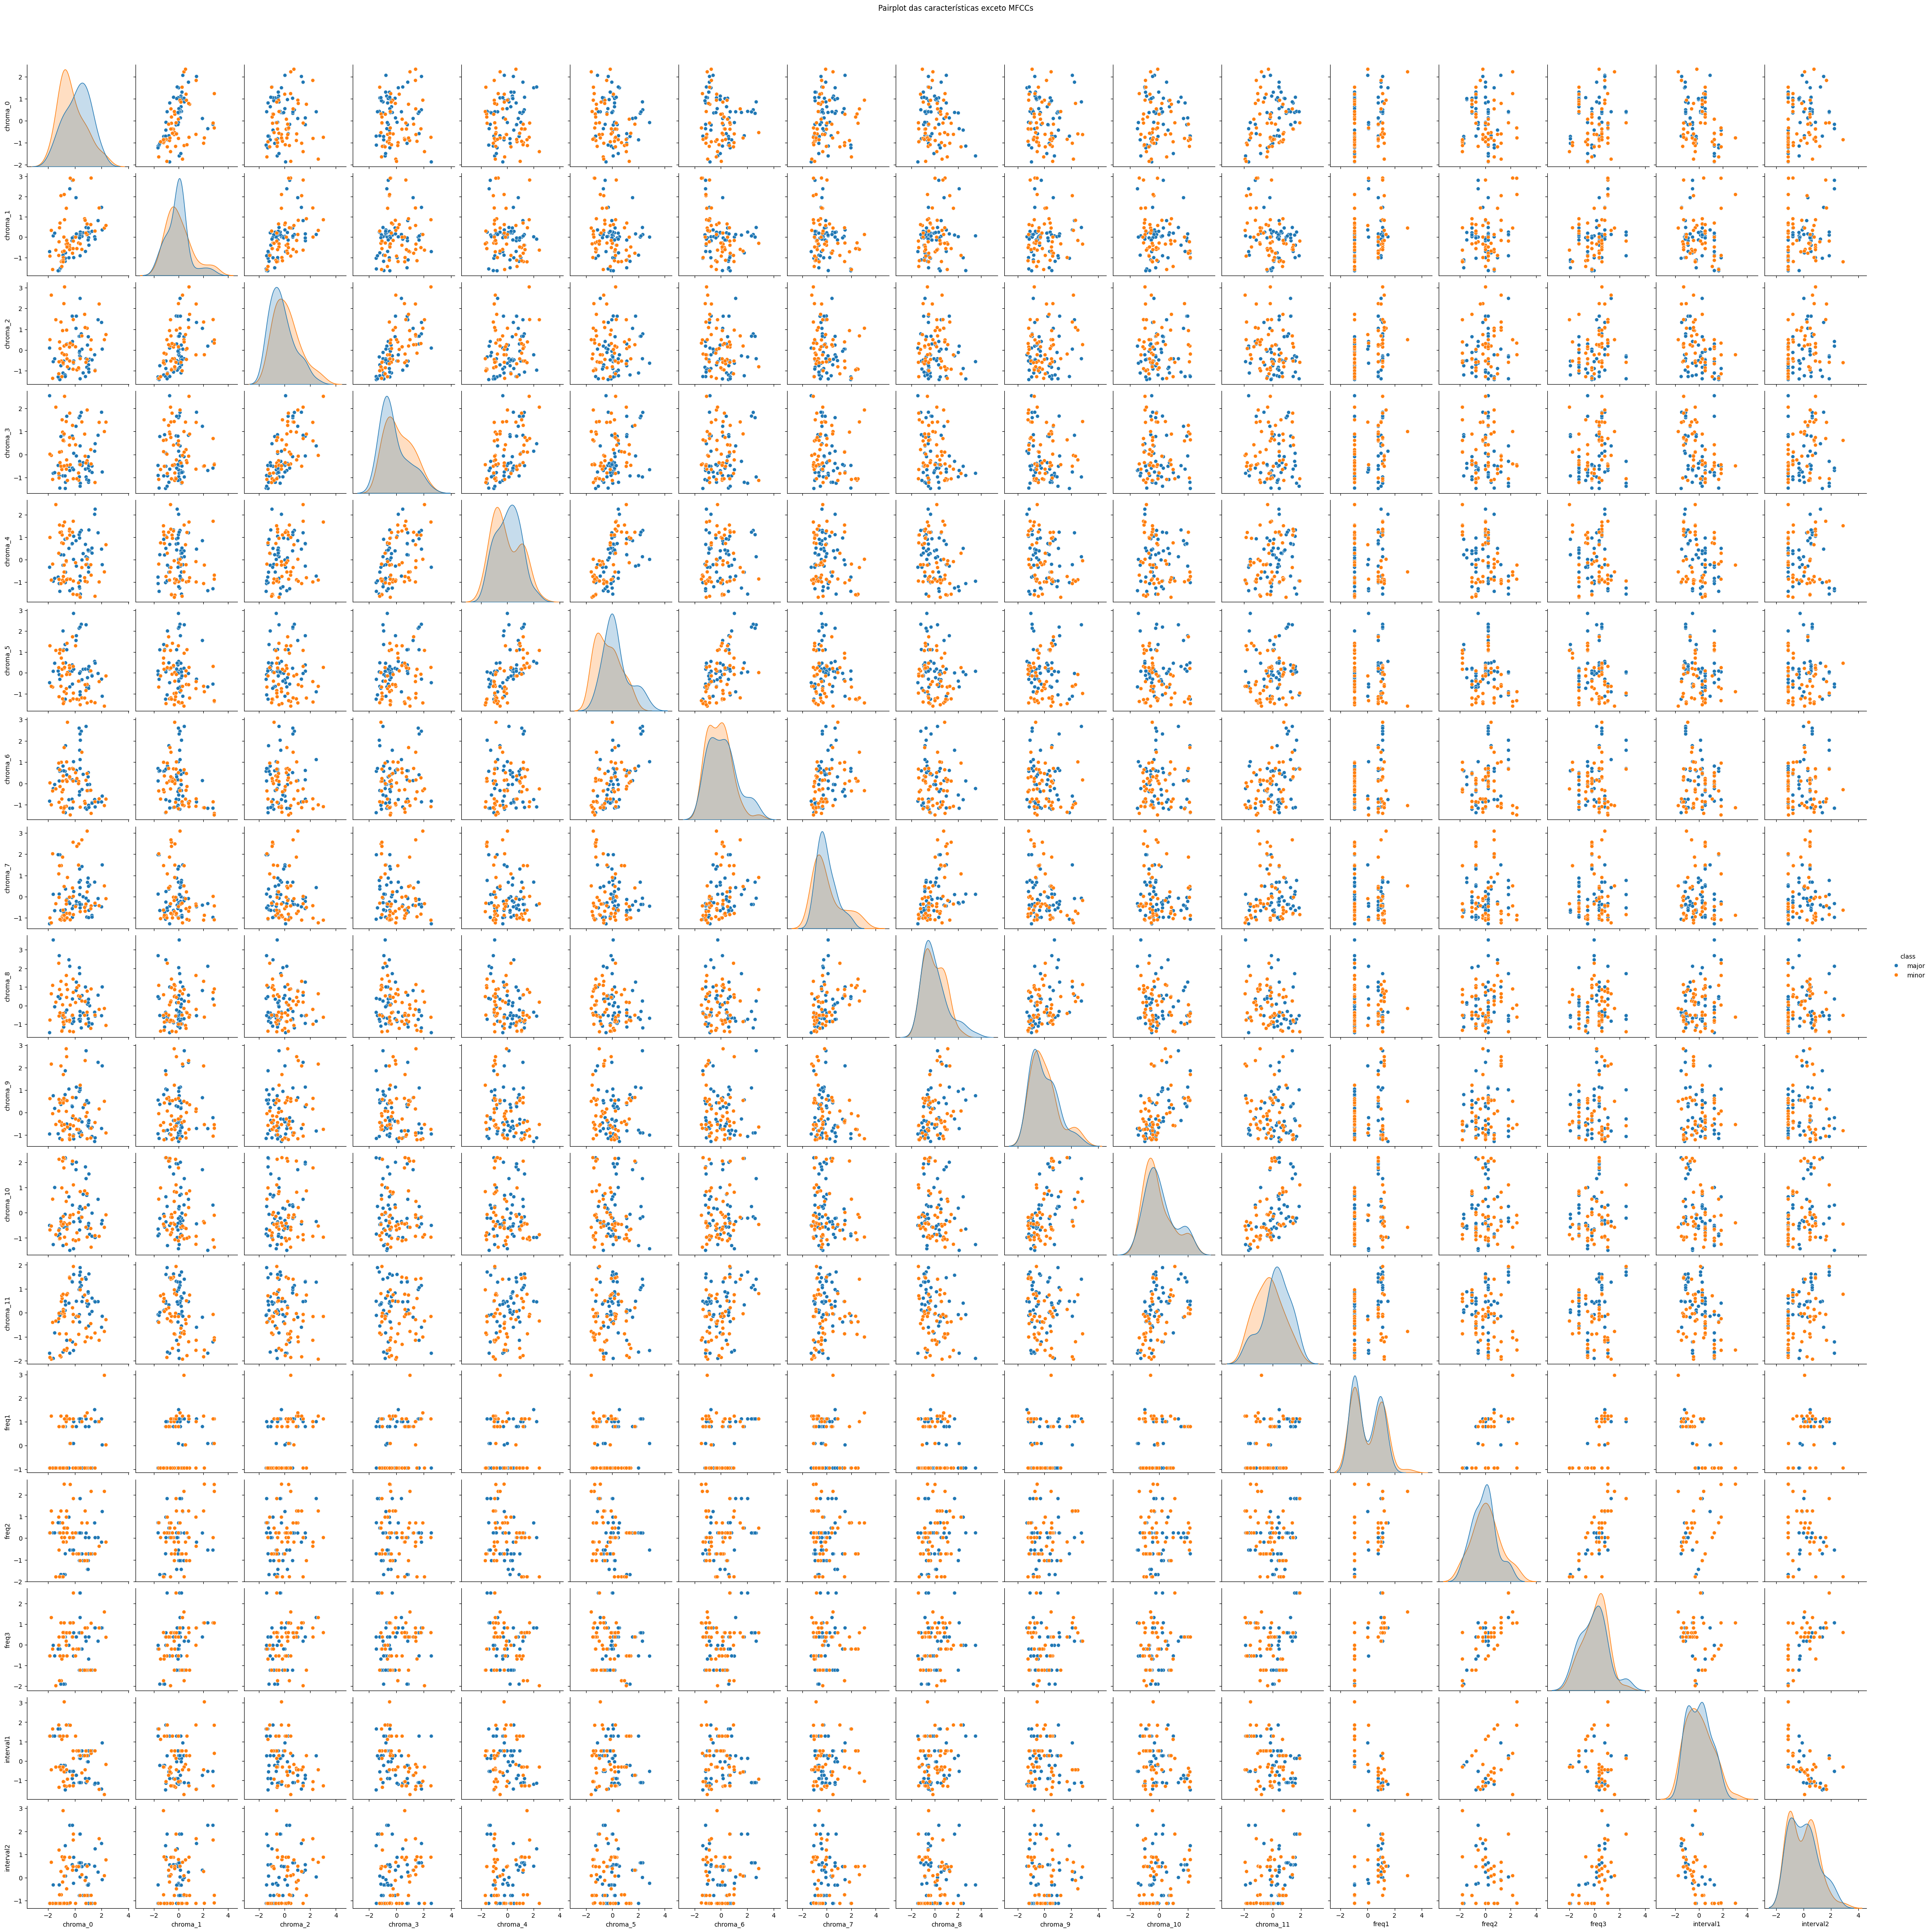

In [134]:
cols_to_plot = [col for col in chords_MFCCs.columns if not col.startswith('mfcc_') and col != 'file']

if 'class' in cols_to_plot:
    cols_to_plot.remove('class')
cols_to_plot.append('class')

sns.pairplot(chords_MFCCs[cols_to_plot], hue='class', diag_kind='kde')

plt.suptitle("Pairplot das características exceto MFCCs", y=1.02)
plt.show()

### Chromas
Pesquisando sobre os chromas, acabei plotando esse gráfico para compreender melhor o conceito desses atributos:

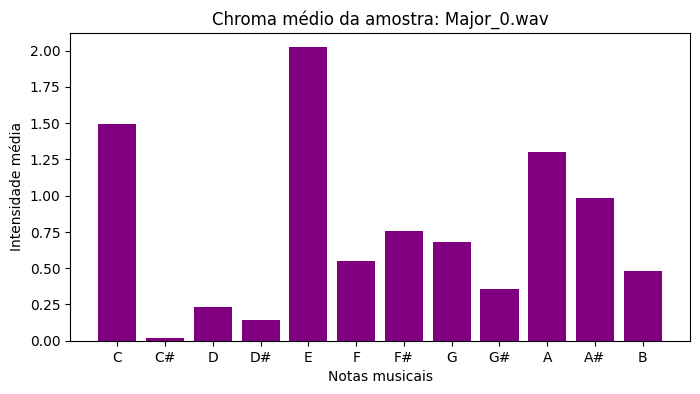

In [135]:
file_to_plot = "Major_0.wav"

sample = chords_MFCCs[chords_MFCCs['file'] == file_to_plot].iloc[0]

# Lista das notas
notas = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

# Extraindo os valores de chroma da amostra
values = [sample[f'chroma_{i}'] for i in range(12)]
values = np.abs(values)

# Plotando o gráfico
plt.figure(figsize=(8, 4))
plt.bar(notas, values, color='purple')
plt.title(f'Chroma médio da amostra: {file_to_plot}')
plt.xlabel('Notas musicais')
plt.ylabel('Intensidade média')
plt.show()

Achei muito interessante. Pelo que vi, o chorma soma as as frequencias das oitavas para preservar somente as notas puras. Isso provavelmente será muito útil.

Vou criar um CSV para ler esse dataframe no arquivo do trabalho em si:


In [136]:
chords_MFCCs.to_csv('./parameters_dataframes/chords_MFCCs.csv', index=False)

Essas foram minhas hipóteses e pesquisas de atributos, agora irei aplicá-los no notebook: "trabalho02" usando K-NN